In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
from brian2.only import *
import seaborn as sns
import deepdish as dd
import scipy.stats as stats

import plot_utils as pu
from digest import get_voltage_histograms
import isi_indexing as ii
from readout import load_results
import spatial

import conf.isi5_500 as cfg
from demonstrator import demonstrator

import styling

In [2]:
labelling = {
    'pspike': pu.labels['pspike'],
    'Threshold': '$\\theta$ (mV)',
    'Vm': pu.labels['Vm']
}
voltage_measures = ('Vm', 'Depression', 'Threshold')
conds = ('std', 'msc', 'dev')
nonstandard = ('msc', 'dev')

In [3]:
net, ipair, istim, isi, templ = [demonstrator[k] for k in ('net', 'ipair', 'istim', 'isi', 'templ')]
pair, stim, Bstim = cfg.pairings[ipair], cfg.pairings[ipair][istim], cfg.pairings[ipair][1-istim]

In [4]:
netf = dd.io.load(cfg.netfile.format(net=net))
X, Y = netf['X']*meter, netf['Y']*meter
W = netf['W']
Xstim, Ystim = spatial.create_stimulus_locations(cfg.params)

In [5]:
def scatter_values(ax, **kwargs):
    m = ax.scatter(X, Y, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-1.1*cfg.params['r_dish'],1.1*cfg.params['r_dish'])
    ax.set_ylim(-1.1*cfg.params['r_dish'],1.1*cfg.params['r_dish'])
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_aspect('equal')
    return m

In [6]:
early = 100

In [7]:
def get_bspikes(res, episode):
    b = np.zeros(np.asarray(res['raw_dynamics']['v'].shape)[[0,2,3]], bool)
    for itrial, (i, spike_t) in enumerate(zip(*[res['raw_spikes'][episode][f'pulsed_{k}'] for k in 'it'])):
        t = (spike_t / cfg.params['dt'] + .5).astype(int)
        b[i, itrial, t] = True
    return b

In [8]:
class Results:
    def __init__(self, net, isi, STD, TA, templ, **kwargs):
        self.res = load_results(cfg.fname.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ), compress=True, tmax=100*msecond, **kwargs)
        self.setup_averages(self.res)
        self.setup_histograms(self.res)
    
    def setup_averages(self, res):
        self.episodes = episodes = {cond: res['pairs'][ipair][cond][stim] for cond in conds}
        self.sequences = sequences = {cond: res['sequences'][episode] for cond, episode in episodes.items()}
        self.trials = trials = {cond: seq == cfg.stimuli[stim] for cond, seq in sequences.items()}
        trials.update({f'{cond}-nontarget': seq != cfg.stimuli[stim] for cond, seq in sequences.items()})
        trials.update({f'{cond}-B': seq == cfg.stimuli[cfg.pairings[ipair][1-istim]] for cond, seq in sequences.items()})

        self.bspikes = {cond: get_bspikes(res, ep) for cond, ep in episodes.items()}

        self.TA_A_dev = res['raw_dynamics']['th_adapt'][:, episodes['dev'], trials[f'dev'], 0].mean(1)*volt/mV
        self.TA_A_msc = res['raw_dynamics']['th_adapt'][:, episodes['msc'], trials[f'msc'], 0].mean(1)*volt/mV
        self.dTA_A = self.TA_A_dev - self.TA_A_msc
        
        self.XA_dev = self.bspikes['dev'][:, trials['dev']].sum(2).mean(1)
        self.XA_msc = self.bspikes['msc'][:, trials['msc']].sum(2).mean(1)
        self.dXA = self.XA_dev - self.XA_msc
        
        self.TA_B_dev = self.TA_notA_dev = res['raw_dynamics']['th_adapt'][:, episodes['dev'], trials[f'dev-B'], 0].mean(1)*volt/mV
        self.TA_B_msc = res['raw_dynamics']['th_adapt'][:, episodes['msc'], trials[f'msc-B'], 0].mean(1)*volt/mV
        self.TA_notA_msc = res['raw_dynamics']['th_adapt'][:, episodes['msc'], ~(trials['msc']|trials['msc-B']), 0].mean(1)*volt/mV
        self.dTA_B = self.TA_B_dev - self.TA_B_msc
        self.dTA_notA = self.TA_notA_dev - self.TA_notA_msc
        
        self.XB_dev = self.XnotA_dev = self.bspikes['dev'][:, trials['dev-B']].sum(2).mean(1)
        self.XB_msc = self.bspikes['msc'][:, trials['msc-B']].sum(2).mean(1)
        self.XnotA_msc = self.bspikes['msc'][:, ~trials['msc']].sum(2).mean(1)
        self.XnotAB_msc = self.bspikes['msc'][:, ~(trials['msc']|trials['msc-B'])].sum(2).mean(1)
        self.dXnotA = self.XnotA_dev - self.XnotA_msc
        
        self.dXB_adaptation = self.XB_dev - self.XB_msc
        self.dXB_stimchange = self.XB_msc - self.XnotA_msc

        index_N, index_t = ii.get_onset_ordering(cfg, np.stack([b[:, trials[f'{cond}-B'], :].mean(1) for cond, b in self.bspikes.items()]))
        self.index_B, self.early, self.late = index_N[:, 0], index_N[:early, 0], index_N[early:, 0]

    def setup_histograms(self, res):
        vhist = get_voltage_histograms(cfg.params, res)
        stimulated = spatial.get_stimulated(X, Y, Xstim, Ystim, cfg.params)[res['stimuli'][cfg.pairings[ipair][istim]]]
        self.histograms = histograms = {cond: {
            'pspike': res['spikes'][ipair][stim][cond]['spike_hist'],
            **{measure: vhist[measure][ipair][stim][cond] for measure in voltage_measures}
        } for cond in conds}
        for cond, h in histograms.items():
            masked = np.copy(h['Vm'])
            masked[stimulated, :10] = np.nan
            h['Vm_masked'] = masked
        
        index_N, index_t = ii.get_onset_ordering(cfg, np.stack([h['pspike'] for h in histograms.values()]))
        pmax = np.amax([histograms[cond]['pspike'].sum(0) for cond in conds], 0)
        self.tmax = np.argmax(np.cumsum(pmax > .01*pmax.max()))
        self.index_N = index_N[:, :self.tmax]
        self.index_t = index_t[:, :self.tmax]
        self.time = np.arange(self.tmax) * cfg.params['dt']

In [9]:
TA = 1
half = Results(net, isi, 0, TA, templ, dynamics_supplements={'u': 'v'})
joint = Results(net, isi, 1, TA, templ, dynamics_supplements={'u': 'v'})
statistics = dd.io.load('stats.h5')

# F4: Initial thresholds shape dev response

In [10]:
def plot_hists_nocb(axs, histograms, index_N, index_t, dt,
                    grid=False, cmap='PiYG', vmin=None, vmax=None, symmetric=True, cscale=False, separate_types=True):
    if type(index_t) == int:
        assert len(index_N.shape) == 1
        index_N = np.repeat(index_N.reshape(-1,1), index_t, 1)
        index_t = np.repeat(np.arange(index_t).reshape(1,-1), len(index_N), 0)
    histograms = np.asarray(histograms)
    x = np.arange(index_t.shape[-1] + 1)*dt/msecond
    y = np.arange(len(index_N)+1)
    
    if symmetric:
        if vmax is None:
            vmax = np.nanmax(np.abs(histograms))
        if vmin is None:
            vmin = -vmax
    else:
        if vmax is None:
            vmax = np.nanmax(histograms)
        if vmin is None:
            vmin = np.nanmin(histograms)

    if separate_types:
        exc = index_N[:, 0] < cfg.params['N_exc']
        index_N = np.concatenate([index_N[exc, :], index_N[~exc, :]], axis=0)
        index_t = np.concatenate([index_t[exc, :], index_t[~exc, :]], axis=0)

    orders = []
    for ax, hist in zip(axs, histograms):
        h = hist[index_N, index_t]
        order = 0
        if cscale:
            hmax, hmin = np.nanmax(h), np.nanmin(h)
            max_order = int(np.log10(vmax/hmax)) if hmax>0 else np.nan
            min_order = int(np.log10(vmin/hmin)) if hmin<0 else np.nan
            order = np.nanmin([max_order, min_order])
            if np.isnan(order):
                order = 1
        orders.append(order)
        m = ax.pcolormesh(x, y, h*10**order, vmin=vmin, vmax=vmax, cmap=cmap, shading='flat', rasterized=True)
        if grid:
            ax.grid()
    return (m, orders) if cscale else m

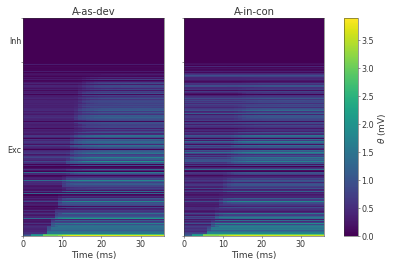

In [11]:
def subpanel_raw(axs, cax, data, measure, title=False):
    unit = 1 if measure == 'pspike' else mV
    hmeasure = 'Vm_masked' if measure == 'Vm' else measure
    m = plot_hists_nocb(
        axs, [data.histograms[cond][hmeasure]/unit for cond in nonstandard[::-1]],
        data.index_N, data.index_t, cfg.params['dt'], cmap=styling.cmap_seq, symmetric=False)
    plt.colorbar(m, cax=cax, label=labelling[measure])
    limits = [0, cfg.params['N_exc'], cfg.params['N']]
    for ax in axs:
        ax.set_xlabel('Time (ms)')
        ax.set_yticks(limits, [])
    axs[0].set_yticks([(lo+hi)/2 for lo, hi in zip(limits, limits[1:])], ['Exc', 'Inh'], minor=True)
    axs[0].tick_params('y', which='minor', length=0, pad=2)
    if title:
        for ax, cond in zip(axs, nonstandard[::-1]):
            ax.set_title(pu.seq[cond])

fig, axs = plt.subplots(1, 3, width_ratios=(1,1,.1))
subpanel_raw(axs[:2], axs[2], half, 'Threshold', title=True)

In [12]:
def subpanel_contrast(ax, cax, data, measure, title=False):
    h = data.histograms['dev'][measure] - data.histograms['msc'][measure]
    if measure != 'pspike':
        h /= mV
    m = plot_hists_nocb(
        [ax], [h],
        data.index_N, data.index_t, cfg.params['dt'], cmap=styling.cmap_div)
    plt.colorbar(m, cax=cax)
    if title:
        ax.set_title(f'{pu.sseq["dev"]} - {pu.sseq["msc"]}')
    ax.set_xlabel('Time (ms)')
    ax.set_yticks([0, cfg.params['N_exc'], cfg.params['N']], [])

WARNING    /home/felix/projects/culture/.env/lib/python3.10/site-packages/brian2/units/fundamentalunits.py:1380: RuntimeWarning: invalid value encountered in true_divide
  result = operation(self_arr, other_arr)
 [py.warnings]
WARNING    /tmp/ipykernel_181074/3429487847.py:32: RuntimeWarning: Mean of empty slice
  ax_mean.plot(time, np.nanmean(pdiff*TA_driving_contrib, 0), color=cmap(1.), label=r'$\overline{C_\theta}$')
 [py.warnings]
WARNING    /tmp/ipykernel_181074/3429487847.py:33: RuntimeWarning: Mean of empty slice
  ax_mean.plot(time, np.nanmean(pdiff*V_driving_contrib, 0), color=cmap(0.), label=r'$\overline{C_{V_m}}$')
 [py.warnings]


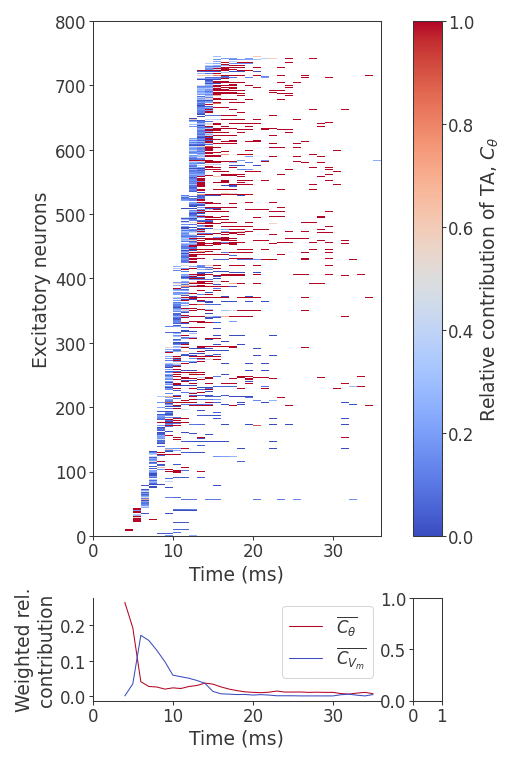

In [13]:
def panel_contrib_TA(ax_hist, cax, ax_mean, data):
    tmax = data.index_t.shape[1]
    time = np.arange(tmax) * cfg.params['dt'] / msecond
    
    # Get contrasts
    dTA = (data.histograms['dev']['Threshold'] - data.histograms['msc']['Threshold'])[:cfg.params['N_exc'], :tmax]
    dV = (data.histograms['dev']['Vm'] - data.histograms['msc']['Vm'])[:cfg.params['N_exc'], :tmax]
    pdiff = (data.histograms['dev']['pspike'] - data.histograms['msc']['pspike'])[:cfg.params['N_exc'], :tmax]
    index_N = data.index_N[data.index_N[:, 0] < cfg.params['N_exc'], :]
    index_t = data.index_t[data.index_N[:, 0] < cfg.params['N_exc'], :]
    
    # Include only greater dev activity: mask by pdiff>0
    mask = pdiff > 0
    pdiff = np.where(mask, pdiff, np.nan)

    # Ignore negative contributions (e.g., lower Vm does not contribute to more firing, thus contribution_Vm = 0)
    dTA_driving = -1 * dTA * (dTA < 0) * mask
    dV_driving = dV * (dV > 0) * mask

    # Take the ratio -- contribution of x relative to total contribution across relevant factors
    TA_driving_contrib = dTA_driving / (dV_driving + dTA_driving)
    V_driving_contrib = 1 - TA_driving_contrib

    # Include only positive contributions to greater dev activity (exclude less dev activity; ignore negative contributions)
    cmap = matplotlib.cm.get_cmap('coolwarm')
    m = plot_hists_nocb([ax_hist], [TA_driving_contrib], index_N, index_t, cfg.params['dt'], cmap=cmap, symmetric=False)
    plt.colorbar(m, cax=cax, label=r'Relative contribution of TA, $C_\theta$')
    ax_hist.set_xlabel('Time (ms)')
    ax_hist.set_ylabel('Excitatory neurons')
    
    # Control for (=weight by) magnitude of delta pspike, and average across neurons
    ax_mean.plot(time, np.nanmean(pdiff*TA_driving_contrib, 0), color=cmap(1.), label=r'$\overline{C_\theta}$')
    ax_mean.plot(time, np.nanmean(pdiff*V_driving_contrib, 0), color=cmap(0.), label=r'$\overline{C_{V_m}}$')
    ax_mean.set_xlim(ax_hist.get_xlim())
    ax_mean.set_xlabel('Time (ms)')
    ax_mean.set_ylabel('Weighted rel.\ncontribution')
    ax_mean.legend()
    sns.despine(ax=ax_mean)

fig, axs = plt.subplots(2, 2, figsize=(3,6), dpi=150, height_ratios=(5,1), width_ratios=(10,1))
panel_contrib_TA(axs[0,0], axs[0,1], axs[1,0], half)

In [14]:
contrib_TA = dd.io.load('contrib_TA.h5')

WARNING    /home/felix/projects/culture/.env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
 [py.warnings]


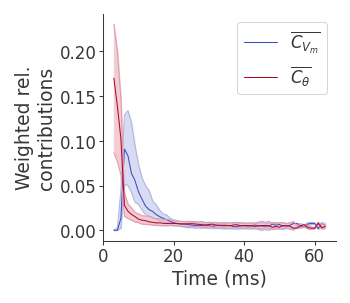

In [15]:
def panel_contrib_TA_stats(ax, STD, br='\n'):
    cmap = matplotlib.cm.get_cmap('coolwarm')
    colors = {'Threshold': cmap(1.), 'Vm': cmap(0.)}
    labels = {'Threshold': r'$\overline{C_\theta}$', 'Vm': r'$\overline{C_{V_m}}$'}
    for key, C in contrib_TA[STD].items():
        time = np.arange(C.shape[-1]) * cfg.params['dt'] / msecond
        q = np.nanquantile(C, (.25, .5, .75), 0)
        ax.fill_between(time, q[0], q[2], color=pu.alpha_to_color(colors[key], alpha=.2))
        for val in (q[0], q[2]):
            ax.plot(time, val, color=pu.alpha_to_color(colors[key], .4))
        ax.plot(time, q[1], color=colors[key], label=labels[key])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel(f'Weighted rel.\ncontributions')
    ax.legend()
    sns.despine(ax=ax)

fig, ax = plt.subplots(figsize=(2,2), dpi=150)
panel_contrib_TA_stats(ax, 0)

Sample dTA vs dSpikes: r = -0.394, p = 2.2e-31
Sample dTA < 0: Z = -20, p = 4.09e-89, median = -0.165


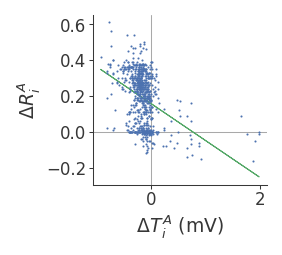

In [16]:
def panel_dTA_scatter(ax, data, ms=1, br='\n'):
    dTheta = data.dTA_A[:cfg.params['N_exc']]
    ax.scatter(dTheta, data.dXA[:cfg.params['N_exc']], s=ms, marker='.', c='b', label='Excitatory', zorder=2)
    regression = stats.linregress(dTheta, data.dXA[:cfg.params['N_exc']], alternative='less')
    ax.plot(data.dTA_A, regression.intercept + regression.slope*data.dTA_A, 'C2', label=f'r={regression.rvalue:.3g},\np={regression.pvalue:.2g}', zorder=1)
    
    ax.axvline(0, **styling.axline_kwargs)
    ax.axhline(0, **styling.axline_kwargs)
    ax.set_xlabel(f'$\\Delta {pu.T(stim="A", index="i")}$ (mV)')
    ax.set_ylabel(f'$\\Delta {{{pu.R(stim="A", index="i")}}}$')
    sns.despine(ax=ax)

    print(f'Sample dTA vs dSpikes: r = {regression.rvalue:.3g}, p = {regression.pvalue:.2g}')

    test = stats.wilcoxon(dTheta, alternative='less', method='approx')
    print(f'Sample dTA < 0: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}, median = {np.median(dTheta):.3f}')

fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=150)
panel_dTA_scatter(ax, half)

607

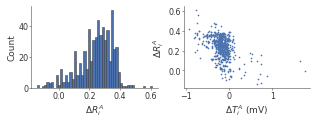

In [17]:
# Addressing Reviewer 3, Figures/Specific/f.

fig, axs = plt.subplots(1,2,figsize=(5,1.5))
mask = (half.XA_dev[:cfg.params['N_exc']] > .1) & (half.XA_dev[:cfg.params['N_exc']] < 1)
axs[0].hist(half.dXA[:cfg.params['N_exc']][mask], bins=50)
axs[0].set_xlabel(f'$\\Delta {{{pu.R(stim="A", index="i")}}}$')
axs[0].set_ylabel('Count')

axs[1].scatter(half.dTA_A[:cfg.params['N_exc']][mask], half.dXA[:cfg.params['N_exc']][mask], s=5, marker='.', c='b', label='Excitatory', zorder=2)
axs[1].set_xlabel(f'$\\Delta {{{pu.T(stim="A", index="i")}}}$ (mV)')
axs[1].set_ylabel(f'$\\Delta {{{pu.R(stim="A", index="i")}}}$')
sns.despine()
mask.sum()

rho < 0: Z = -9.4, p = 2.68e-21, median = -0.357
dV_TA < 0: Z = -8.16, p = 1.67e-16, median = -0.094


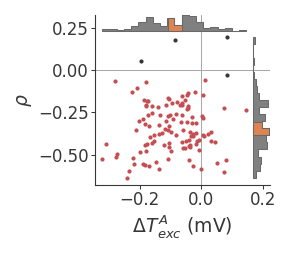

In [18]:
def panel_dTA_drives_dA(ax, STD, ms=2, xsuffix=''):
    dTheta = statistics['dTA_A'][STD][:, :cfg.params['N_exc']]
    dX = statistics['dXA'][STD][1][:, :cfg.params['N_exc']]
    r, s = [], []
    for dth, dx in zip(dTheta, dX):
        regression = stats.linregress(
            dth, dx,
            alternative='less')
        ax.plot(np.median(dth), regression.rvalue, '.', ms=ms, c='r' if regression.pvalue < .05 else styling.offblack, zorder=1)
        r.append(regression.rvalue)
        s.append(np.median(dth))
    ax.set_xlabel(f'$\\Delta {pu.T(stim="A", index="exc")}$ (mV){xsuffix}')
    ax.set_ylabel('$\\rho$')
    pu.inset_hist(ax, r, False)
    pu.inset_hist(ax, s, True)
    ax.axhline(0, **styling.axline_kwargs)
    ax.axvline(0, **styling.axline_kwargs)
    sns.despine(ax=ax)
    
    test = stats.wilcoxon(r, alternative='less', method='approx')
    print(f'rho < 0: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}, median = {np.median(r):.3f}')
    test = stats.wilcoxon(s, alternative='less', method='approx')
    print(f'dV_TA < 0: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}, median = {np.median(s):.3f}')

fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=150)
panel_dTA_drives_dA(ax, 0)

WARNING    /home/felix/projects/culture/plot_utils.py:142: RuntimeWarning: divide by zero encountered in long_scalars
  ratios[ratios<0] = remainder / (ratios<0).sum()
 [py.warnings]


No STD:
Sample dTA vs dSpikes: r = -0.394, p = 2.2e-31
Sample dTA < 0: Z = -20, p = 4.09e-89, median = -0.165


WARNING    /tmp/ipykernel_181074/3429487847.py:32: RuntimeWarning: Mean of empty slice
  ax_mean.plot(time, np.nanmean(pdiff*TA_driving_contrib, 0), color=cmap(1.), label=r'$\overline{C_\theta}$')
 [py.warnings]
WARNING    /tmp/ipykernel_181074/3429487847.py:33: RuntimeWarning: Mean of empty slice
  ax_mean.plot(time, np.nanmean(pdiff*V_driving_contrib, 0), color=cmap(0.), label=r'$\overline{C_{V_m}}$')
 [py.warnings]


rho < 0: Z = -9.4, p = 2.68e-21, median = -0.357
dV_TA < 0: Z = -8.16, p = 1.67e-16, median = -0.094

With STD:
Sample dTA vs dSpikes: r = -0.461, p = 1.1e-43
Sample dTA < 0: Z = -21.7, p = 2.48e-104, median = -0.271
rho < 0: Z = -9.43, p = 2.09e-21, median = -0.268
dV_TA < 0: Z = -8.26, p = 7.29e-17, median = -0.107


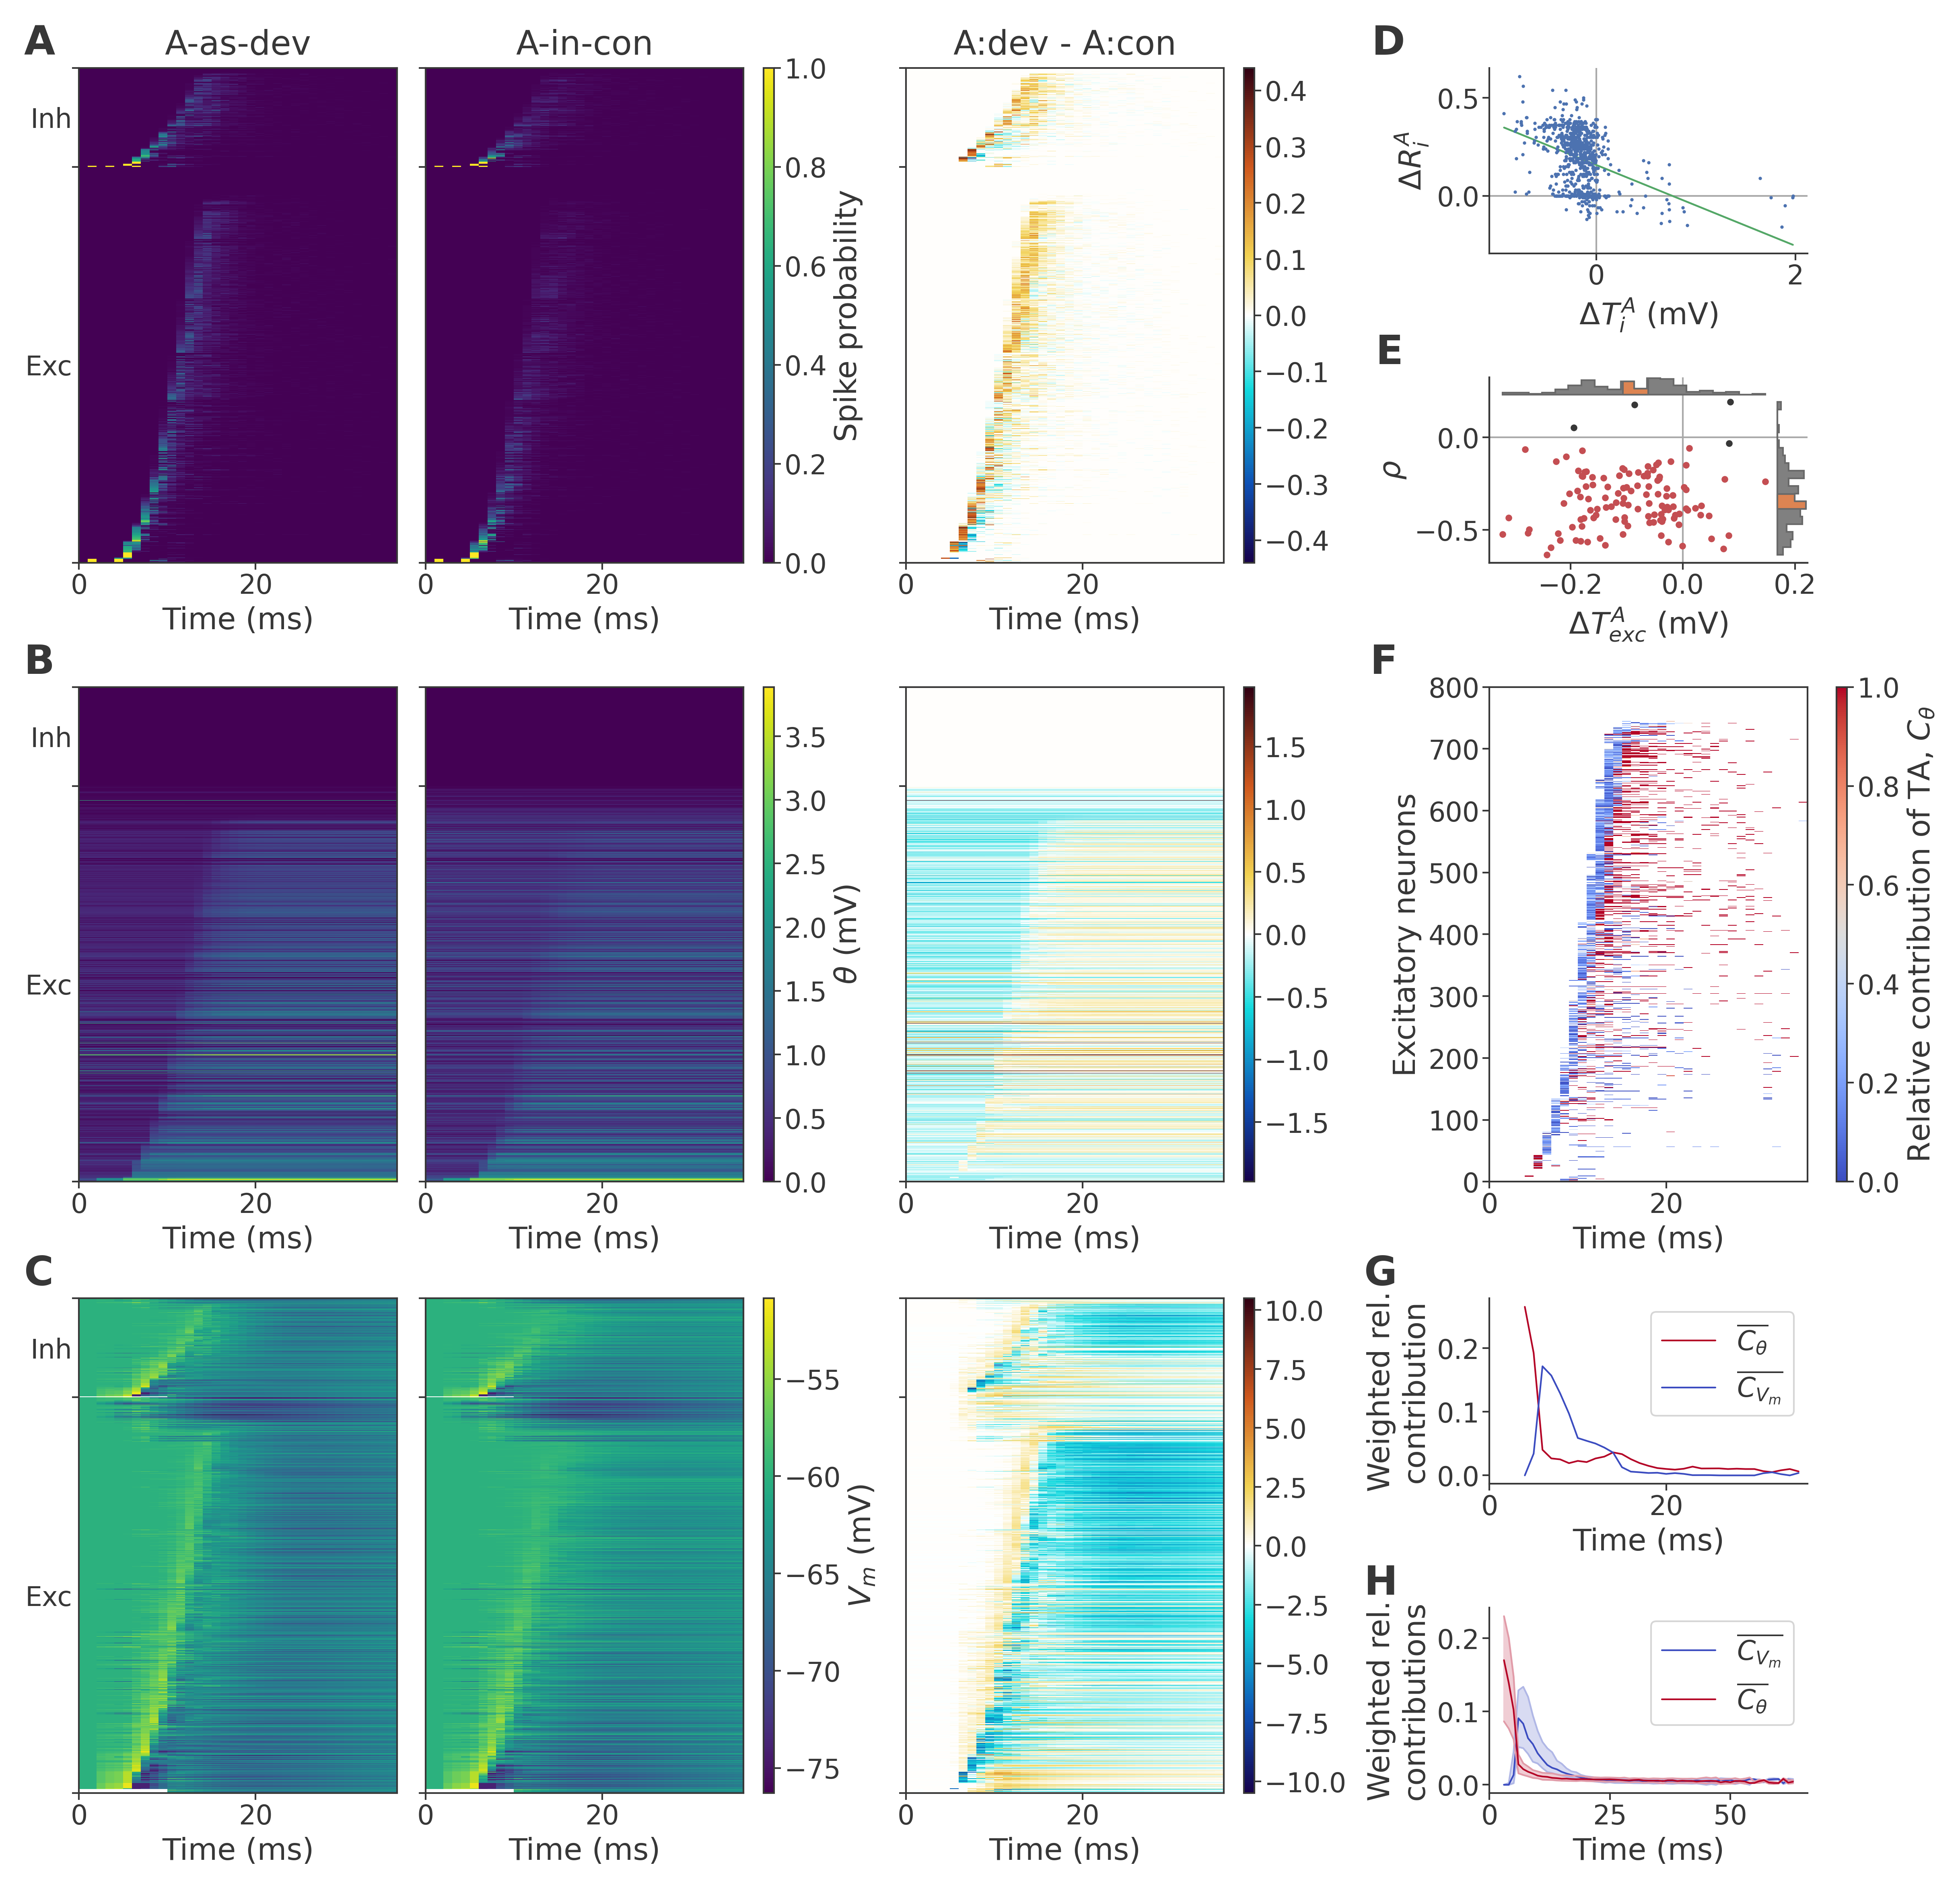

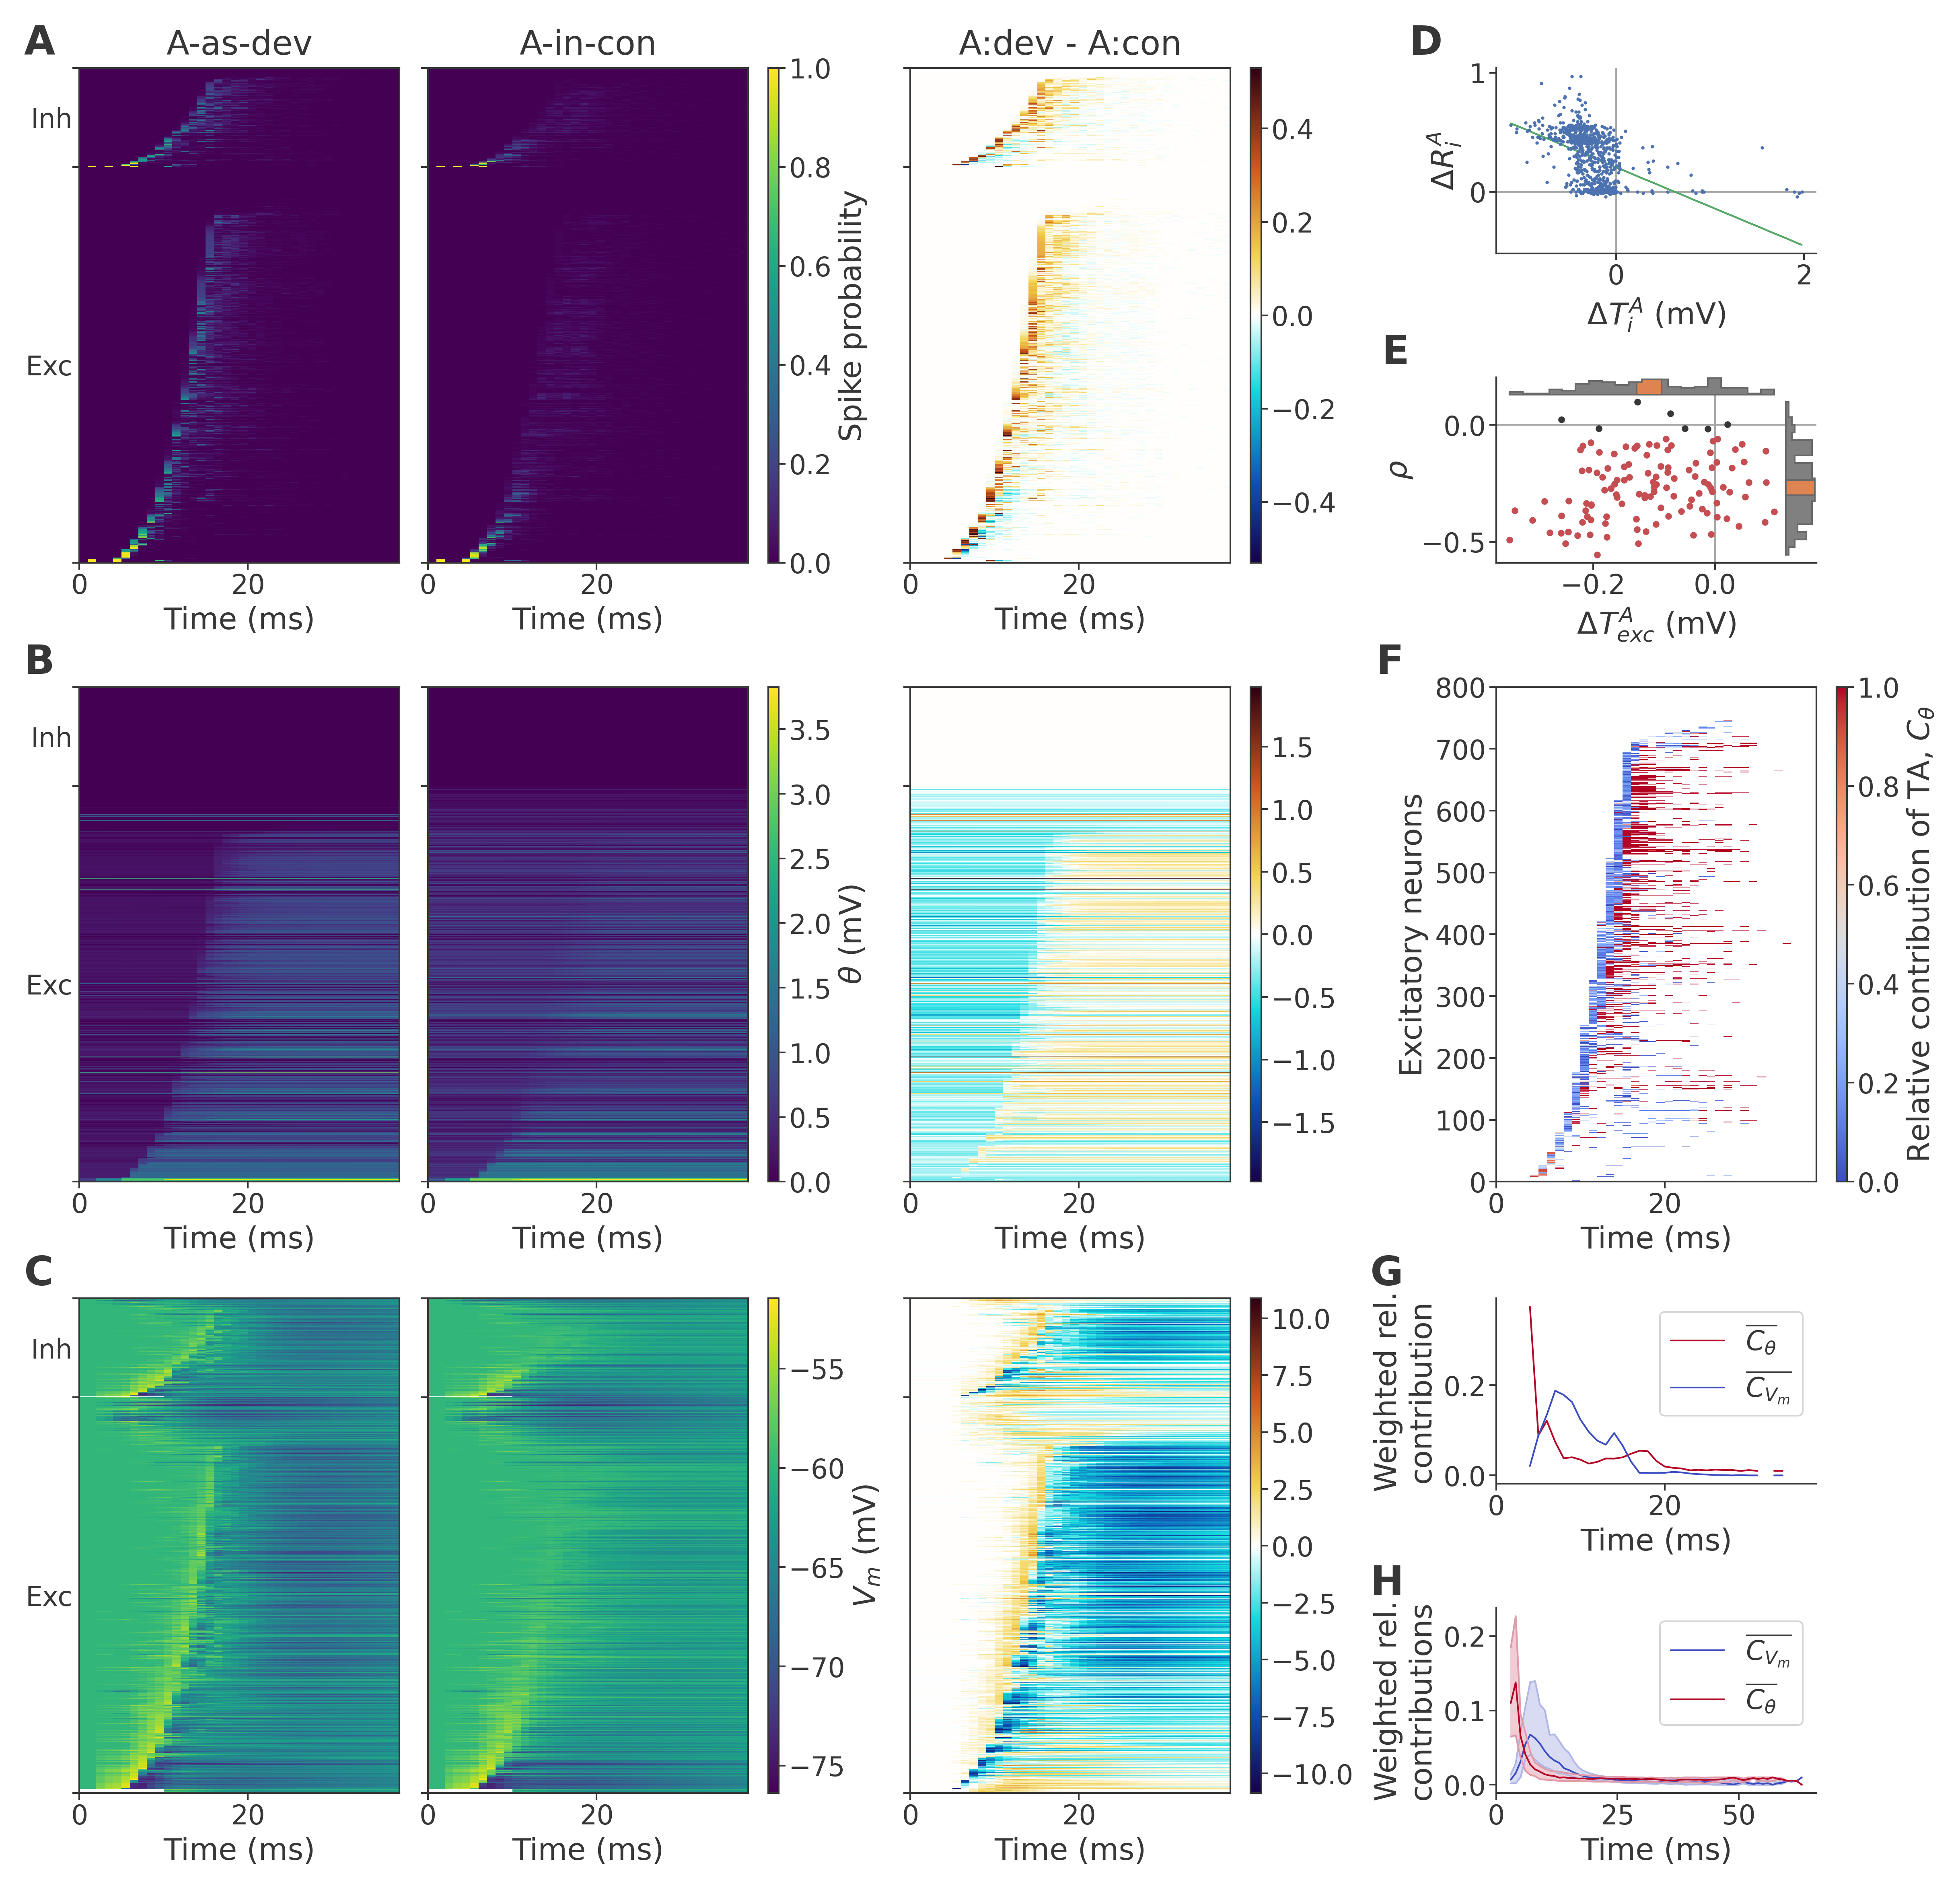

In [19]:
def make_figure_4(data, STD):
    fig = plt.figure(figsize=pu.fullwidth(6), dpi=600, layout='constrained')
    gs = fig.add_gridspec(6, 7, width_ratios=pu.fill_ratios(30,30,1,30,1,30,1))

    for row, measure in enumerate(('pspike', 'Threshold', 'Vm')):
        ax_cbar_raw = fig.add_subplot(gs[2*row:2*(row+1), 2])
        ax_ = fig.add_subplot(gs[2*row:2*(row+1), 0])
        axs_hist_raw = [ax_, fig.add_subplot(gs[2*row:2*(row+1), 1], sharex=ax_)]
        subpanel_raw(axs_hist_raw, ax_cbar_raw, data, measure, title=row==0)
        pu.label_panel(ax_, row)

        ax_cbar_contrast = fig.add_subplot(gs[2*row:2*(row+1), 4])
        ax_hist_contrast = fig.add_subplot(gs[2*row:2*(row+1), 3], sharex=ax_)
        subpanel_contrast(ax_hist_contrast, ax_cbar_contrast, data, measure, title=row==0)

    ax = fig.add_subplot(gs[0, 5])
    panel_dTA_scatter(ax, data)
    pu.label_panel(ax, 3, left=1.2)

    ax = fig.add_subplot(gs[1, 5])
    panel_dTA_drives_dA(ax, STD)
    pu.label_panel(ax, 4, left=1)

    ax_hist, cax = fig.add_subplot(gs[2:4, 5]), fig.add_subplot(gs[2:4, -1])
    ax_mean = fig.add_subplot(gs[4, 5])
    panel_contrib_TA(ax_hist, cax, ax_mean, data)
    pu.label_panel(ax_hist, 5, left=1.2)
    pu.label_panel(ax_mean, 6)

    ax_stats = fig.add_subplot(gs[5, 5])
    panel_contrib_TA_stats(ax_stats, STD)
    pu.label_panel(ax_stats, 7)

    fig.get_layout_engine().set(h_pad=0, hspace=0)

print('No STD:')
make_figure_4(half, 0)
plt.savefig('paper-1/Fig4.tif', pil_kwargs={"compression": "tiff_lzw"}, dpi=600)
plt.savefig('paper-1/fig-threshold-initial.pdf')

print('\nWith STD:')
make_figure_4(joint, 1)
plt.savefig('paper-1/S1_fig.pdf')

# F5: Thresholds follow the std response magnitude

In [20]:
def spatial_contrast(axs_raw, cax_raw, ax_contrast, cax_contrast, dev, msc, diff, ms=1, raw_symmetric=False, raw_also=[], contrast_also=[]):
    vmax = np.abs([dev, msc] + raw_also).max()
    vmin = -vmax if raw_symmetric else 0
    cmap_raw = styling.cmap_div if raw_symmetric else styling.cmap_seq
    m = scatter_values(axs_raw[0], c=dev, s=ms, vmin=vmin, vmax=vmax, cmap=cmap_raw)
    m = scatter_values(axs_raw[1], c=msc, s=ms, vmin=vmin, vmax=vmax, cmap=cmap_raw)
    plt.colorbar(m, cax=cax_raw)

    if ax_contrast is None:
        return

    vmax = np.abs([diff] + contrast_also).max()
    m = scatter_values(ax_contrast, c=diff, s=ms, vmin=-vmax, vmax=vmax, cmap=styling.cmap_div)
    plt.colorbar(m, cax=cax_contrast)

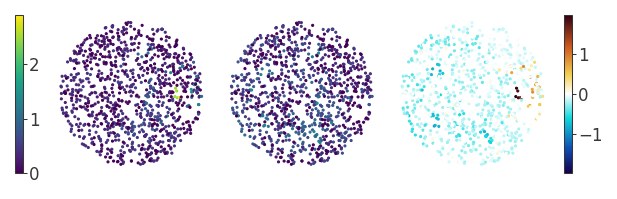

In [21]:
fig, axs = plt.subplots(1, 5, figsize=(4, 2), gridspec_kw={'width_ratios': (.1,2,2,2,.1)}, dpi=150, layout='compressed')
spatial_contrast(axs[1:3], axs[0], axs[3], axs[4], half.TA_A_dev, half.TA_A_msc, half.dTA_A)

notA spikes vs A TA (demonstrator): r = 0.985, p = 0


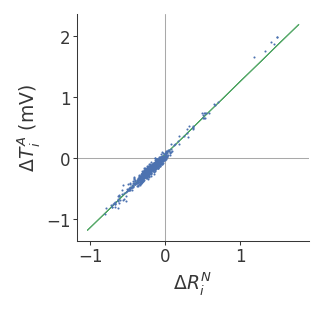

In [22]:
def panel_TAvSpikes(ax, data, ms=1):
    ax.scatter(data.dXnotA[:cfg.params['N_exc']], data.dTA_A[:cfg.params['N_exc']], s=ms, marker='.', c='b', label='Excitatory', zorder=2)
    regression = stats.linregress(data.dXnotA[:cfg.params['N_exc']], data.dTA_A[:cfg.params['N_exc']])
    ax.plot(data.dXnotA, regression.intercept + regression.slope*data.dXnotA, 'C2', label=f'r={regression.rvalue:.3g}, p={regression.pvalue:.2g}', zorder=1)

    ax.axvline(0, **styling.axline_kwargs)
    ax.axhline(0, **styling.axline_kwargs)
    ax.set_xlabel(f'$\\Delta {pu.R(stim="N", index="i")}$')
    ax.set_ylabel(f'$\\Delta {pu.T(stim="A", index="i")}$ (mV)')
    sns.despine(ax=ax)

    print(f'notA spikes vs A TA (demonstrator): r = {regression.rvalue:.3g}, p = {regression.pvalue:.3g}')
fig, ax = plt.subplots(figsize=(2,2), dpi=150)
panel_TAvSpikes(ax, half)

rho > 0: Z = 9.51, p = 9.86e-22, median = 0.990
dXnotA < 0: Z = -8.13, p = 2.12e-16, median = -0.094


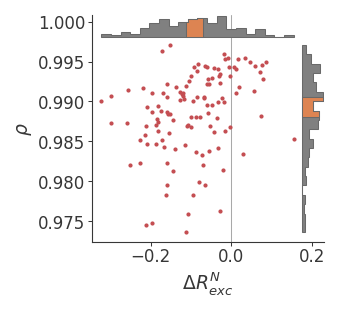

In [23]:
def panel_dXnotA_drives_dTA(ax, STD, ms=2, xsuffix=''):
    r, s = [], []
    for dx, dth in zip(statistics['dXnotA'][STD][1], statistics['dTA_A'][STD]):
        regression = stats.linregress(
            dx[:cfg.params['N_exc']],
            dth[:cfg.params['N_exc']],
            alternative='greater')
        ax.plot(np.median(dx[:cfg.params['N_exc']]), regression.rvalue, '.', ms=ms, c='r' if regression.pvalue < .05 else styling.offblack, zorder=1)
        r.append(regression.rvalue)
        s.append(np.median(dx[:cfg.params['N_exc']]))
    pu.inset_hist(ax, r, False)
    pu.inset_hist(ax, s, True)
    
    ax.set_xlabel(f'$\\Delta {pu.R(stim="N", index="exc")}${xsuffix}')
    ax.set_ylabel('$\\rho$')
    ax.axhline(0, **styling.axline_kwargs)
    ax.axvline(0, **styling.axline_kwargs)
    sns.despine(ax=ax)
    
    test = stats.wilcoxon(r, alternative='greater', method='approx')
    print(f'rho > 0: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}, median = {np.median(r):.3f}')
    test = stats.wilcoxon(s, alternative='less', method='approx')
    print(f'dXnotA < 0: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}, median = {np.median(s):.3f}')

fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
panel_dXnotA_drives_dTA(ax, 0)

In [24]:
def draw_stim_loc(ax):
    for s, AB in zip((stim, Bstim), 'AB'):
        x, y = [c[joint.res['stimuli'][s]] for c in (Xstim, Ystim)]
        r = 0.12 * cfg.params['r_dish']  # Patch radius
        k = 1.02 * cfg.params['r_dish']/cfg.params['stim_distribution_radius']  # Annotation radius
        lpoints = np.asarray([1 + r/cfg.params['stim_distribution_radius'], k])
        ax.plot([x], [y], '*', ms=6, markeredgecolor=styling.offblack, markerfacecolor='magenta', markeredgewidth=.5)
        ax.plot(lpoints*x, lpoints*y, 'grey', clip_on=False)
        ax.text(k*x, k*y, AB, ha='left' if x>=0 else 'right', va='bottom' if y>=0 else 'top', **styling.annotation_kwargs)

No STD:
notA spikes vs A TA (demonstrator): r = 0.985, p = 0
rho > 0: Z = 9.51, p = 9.86e-22, median = 0.990
dXnotA < 0: Z = -8.13, p = 2.12e-16, median = -0.094

With STD:
notA spikes vs A TA (demonstrator): r = 0.982, p = 0
rho > 0: Z = 9.51, p = 9.86e-22, median = 0.989
dXnotA < 0: Z = -8.32, p = 4.41e-17, median = -0.128


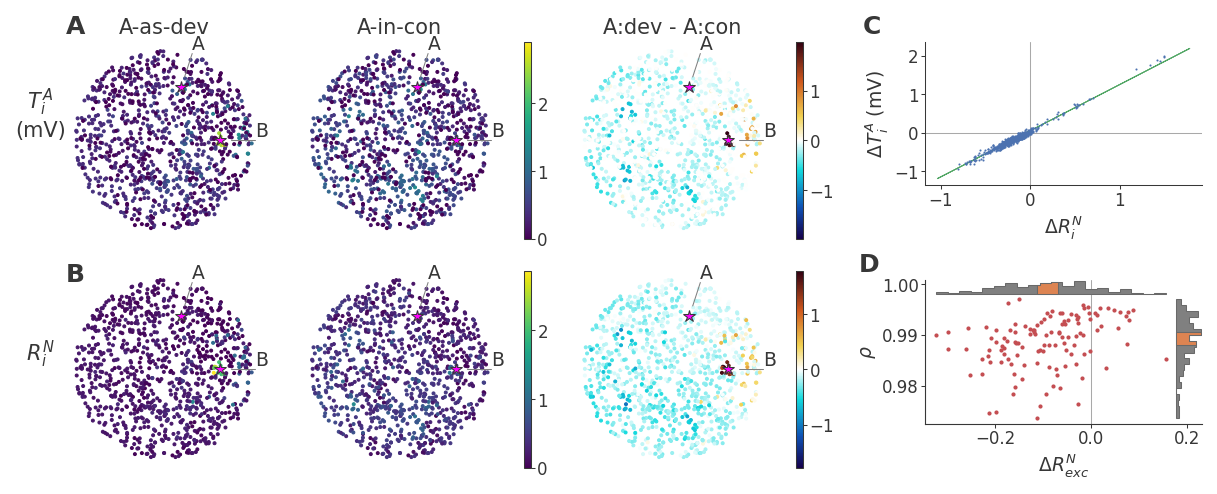

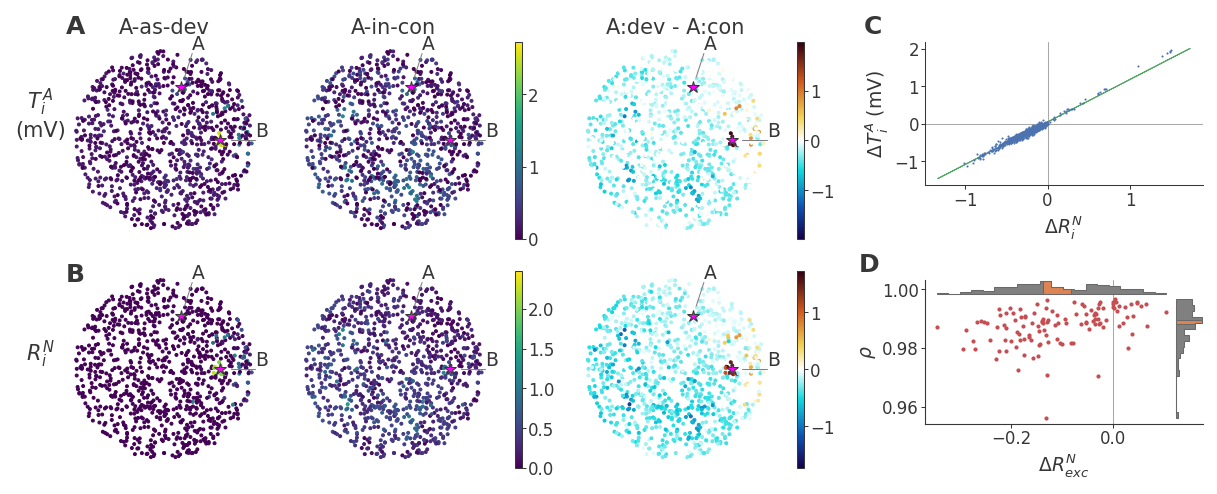

In [25]:
def make_figure_5(data, STD):
    fig = plt.figure(figsize=pu.fullwidth(2.5), dpi=150, layout='compressed')
    gs_top = fig.add_gridspec(1, 2, width_ratios=(7,3))

    subfig_left = fig.add_subfigure(gs_top[0])
    wr = pu.fill_ratios(-1, -1, 1, -1, 1)
    gs_left = subfig_left.add_gridspec(2, 5, width_ratios=wr)

    for row, (measure, title) in enumerate((('TA_A', f'${pu.T(stim="A", index="i")}$\n(mV)'),
                                            ('XnotA', f'${pu.R(stim="N", index="i")}$'))):
        cax_raw = subfig_left.add_subplot(gs_left[row, 2])
        axs_raw = [subfig_left.add_subplot(gs_left[row, i]) for i in range(2)]
        ax_diff = subfig_left.add_subplot(gs_left[row, 3])
        cax_diff = subfig_left.add_subplot(gs_left[row, 4])
        spatial_contrast(axs_raw, cax_raw, ax_diff, cax_diff, *[getattr(data, f'{measure}_{cond}') for cond in ('dev', 'msc')], getattr(data, f'd{measure}'), ms=2)
        if row == 0:
            axs_raw[0].set_title(pu.seq['dev'])
            axs_raw[1].set_title(pu.seq['msc'])
            ax_diff.set_title(f'{pu.sseq["dev"]} - {pu.sseq["msc"]}')
        for ax in axs_raw + [ax_diff]:
            draw_stim_loc(ax)
        axs_raw[0].set_ylabel(title, rotation=0, ha='center', fontsize=plt.rcParams['axes.titlesize'], labelpad=10)
        pu.label_panel(axs_raw[0], row, lower=row>0, left=0)

    subfig_right = fig.add_subfigure(gs_top[1])
    gs_summaries = subfig_right.add_gridspec(2,1)

    ax = subfig_right.add_subplot(gs_summaries[0])
    panel_TAvSpikes(ax, data)
    pu.label_panel(ax, 2)

    ax = subfig_right.add_subplot(gs_summaries[1])
    panel_dXnotA_drives_dTA(ax, STD)
    pu.label_panel(ax, 3)

print('No STD:')
make_figure_5(half, 0)
plt.savefig('paper-1/Fig5.tif', pil_kwargs={"compression": "tiff_lzw"}, dpi=600)
plt.savefig('paper-1/fig-thresholds-follow-std.pdf')

print('\nWith STD:')
make_figure_5(joint, 1)
plt.savefig('paper-1/S2_fig.pdf')

# F6: Early adaptation drives standard response reduction

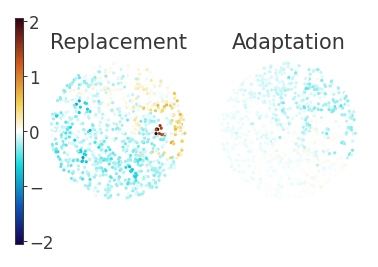

In [26]:
def panel_nontarget_causes_spatial(axs, cax, stimchange, adaptation, ms=1):
    vmax = max(*[np.abs(val).max() for val in (adaptation, stimchange)])
    scatter_values(axs[0], c=stimchange, s=ms, vmin=-vmax, vmax=vmax, cmap=styling.cmap_div)
    axs[0].set_title('Replacement')
    m = scatter_values(axs[1], c=adaptation, s=ms, vmin=-vmax, vmax=vmax, cmap=styling.cmap_div)
    axs[1].set_title('Adaptation')
    plt.colorbar(m, cax=cax)
    for ax in axs:
        ax.set_aspect('equal')

fig, axs = plt.subplots(1, 3, figsize=(3, 2), gridspec_kw={'width_ratios': (.1, 2, 2)}, dpi=150)
panel_nontarget_causes_spatial(axs[1:], axs[0], half.dXB_stimchange, half.dXB_adaptation)

Replacement != 0: Z = -0.471, p = 0.637
Adaptation < 0: Z = -7.23, p = 2.4e-13
Adaptation < Replacement: Z = -2.46, p = 0.00696


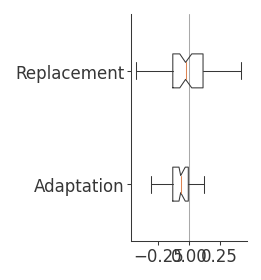

In [27]:
def panel_nontarget_causes_stats(ax, stimchange, adaptation, vert=False):
    if vert:
        ax.axhline(0, **styling.axline_kwargs)
    else:
        ax.axvline(0, **styling.axline_kwargs)
    ax.boxplot([change.mean(1) for change in (stimchange, adaptation)], notch=True, bootstrap=10000,
               labels=['Replacement', 'Adaptation'], widths=.3, vert=vert, positions=(1-vert,vert))
    # ax.set_ylabel('$\\Delta$ spikes per trial and neuron')
    sns.despine(ax=ax)
    
    test = stats.wilcoxon(stimchange.mean(1), alternative='two-sided', method='approx')
    print(f'Replacement != 0: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.wilcoxon(adaptation.mean(1), alternative='less', method='approx')
    print(f'Adaptation < 0: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.wilcoxon(adaptation.mean(1), stimchange.mean(1), alternative='less', method='approx')
    print(f'Adaptation < Replacement: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}')
fig, ax = plt.subplots(figsize=(1,2), dpi=150)
panel_nontarget_causes_stats(ax, *[statistics[k][0][1] for k in ('stimchange', 'adaptation')])

dTA (B, early) ~ dXB: $\rho$ = -0.587, p = 9.56e-13


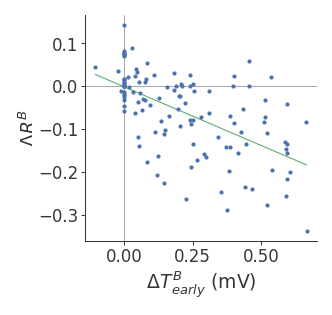

In [28]:
def panel_dTABearly_drives_dXB(ax, STD, ms=2):
    dTheta, dX = statistics['dTA_B_early'][STD], np.median(statistics['adaptation'][STD][1], 1)
    ax.plot(dTheta, dX, '.', ms=ms)
    reg = stats.linregress(dTheta, dX, alternative='less')
    lohi = np.asarray([dTheta.min(), dTheta.max()])
    ax.plot(lohi, lohi*reg.slope + reg.intercept, 'C2', zorder=1)

    ax.axvline(0, **styling.axline_kwargs)
    ax.axhline(0, **styling.axline_kwargs)
    ax.set_xlabel(f'$\\Delta {pu.T(stim="B", index="early")}$ (mV)')
    ax.set_ylabel(f'$\\Delta {pu.R(stim="B")}$')
    sns.despine(ax=ax)

    print(f'dTA (B, early) ~ dXB: $\\rho$ = {reg.rvalue:.3g}, p = {reg.pvalue:.3g}')

fig, ax = plt.subplots(figsize=(2,2), dpi=150)
panel_dTABearly_drives_dXB(ax, 0)

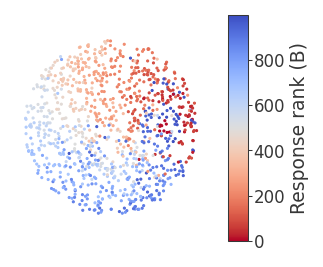

In [29]:
def panel_RB_latency(ax, cax, data, ms=1):
    m = scatter_values(ax, c=np.argsort(data.index_B), cmap='coolwarm_r', s=ms)
    plt.colorbar(m, cax=cax, label='Response rank (B)')

fig, axs = plt.subplots(1, 2, figsize=(2,2), dpi=150, width_ratios=(10,1))
panel_RB_latency(*axs, joint)

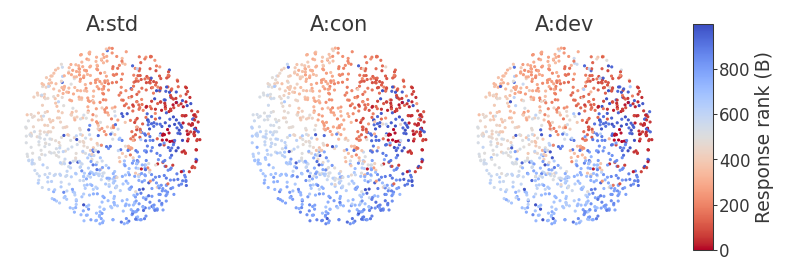

In [30]:
def panel_RB_latency_separate_sequences(axs, cax, data, ms=1):
    for ax, (cond, b) in zip(axs, data.bspikes.items()):
        index_N, index_t = ii.get_onset_ordering(cfg, b[:, data.trials[f'{cond}-B'], :].mean(1))
        index_B = index_N[:, 0]
        m = scatter_values(ax, c=np.argsort(index_B), cmap='coolwarm_r', s=ms)
        ax.set_title(pu.sseq[cond])
    plt.colorbar(m, cax=cax, label='Response rank (B)')
fig, axs = plt.subplots(1, 4, figsize=(6,2), dpi=150, width_ratios=(10,10,10,1))
panel_RB_latency_separate_sequences(axs[:-1], axs[-1], joint)
plt.savefig('paper-1/S7_fig.pdf')

Sample rho = 0.982 > 0: p = 0


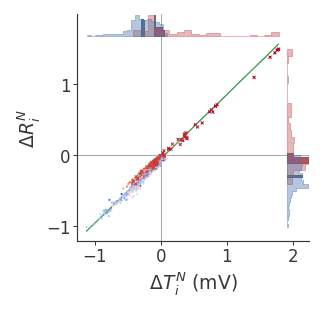

In [30]:
def panel_early_sample(ax, data, portion='both'):
    rank = np.argsort(data.index_B)
    mask = rank<early

    # Limit to excitatory (early is a first-n-responders limit, not a time limit!)
    mask = mask[:cfg.params['N_exc']]
    rank = rank[:cfg.params['N_exc']]
    
    dX = data.dXnotA[:cfg.params['N_exc']]
    dTA = data.dTA_notA[:cfg.params['N_exc']]

    if portion in ('both', 'late'):
        ax.scatter(dTA[~mask], dX[~mask], c=rank[~mask], marker='.', s=1, cmap='coolwarm_r',
            vmin=0, vmax=cfg.params['N'], zorder=2)
    if portion in ('both', 'early'):
        ax.scatter(dTA[mask], dX[mask], c=rank[mask], marker='x' if portion=='both' else '.', s=2, cmap='coolwarm_r',
            vmin=0, vmax=cfg.params['N'], zorder=2)
    reg = stats.linregress(dTA, dX, alternative='greater')
    ax.plot(dTA, reg.slope*dTA + reg.intercept, c='C2', zorder=1)

    if portion in ('both', 'early'):
        pu.inset_hist(ax, dX[mask], x=False, median_color='r', color='r', alpha=.4, edgecolor='r')
        pu.inset_hist(ax, dTA[mask], median_color='r', color='r', alpha=.4, edgecolor='r')
    if portion in ('both', 'late'):
        pu.inset_hist(ax, dX[~mask], x=False, median_color='b', color='b', alpha=.4, edgecolor='b', rescale=(portion!='both'))
        pu.inset_hist(ax, dTA[~mask], median_color='b', color='b', alpha=.4, edgecolor='b', rescale=(portion!='both'))

    ax.axvline(0, **styling.axline_kwargs)
    ax.axhline(0, **styling.axline_kwargs)
    ax.set_ylabel(f'$\\Delta {pu.R(stim="N", index="i")}$')
    ax.set_xlabel(f'$\\Delta {pu.T(stim="N", index="i")}$ (mV)')
    if portion != 'both':
        ax.set_title(portion)
    sns.despine(ax=ax)

    print(f'Sample rho = {reg.rvalue:.3g} > 0: p = {reg.pvalue:.3g}')

fig, ax = plt.subplots(figsize=(2,2), dpi=150)
panel_early_sample(ax, joint)

dXnotA ~ dTA_B, rho > 0: Z = 9.51, p = 9.86e-22, median = 0.992
early dXnotA > 0: Z = 8.78, p = 8.48e-19
late dXnotA < 0: Z = -8.73, p = 1.23e-18
all dXnotA < 0: Z = -8.21, p = 1.07e-16
early dTA_B > 0: Z = 8.4, p = 2.21e-17
late dTA_B < 0: Z = -8.37, p = 2.97e-17
all dTA_B < 0: Z = -7.96, p = 8.7e-16


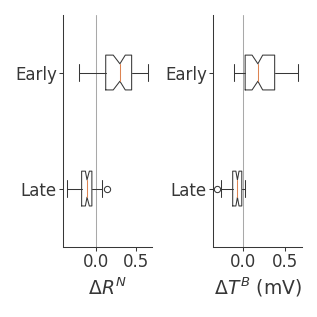

In [31]:
def panel_early_stats(axs, STD, vert=False):
    def plot(ax, early, late, label):
        ax.boxplot(
            [early, late], labels=['Early', 'Late'], widths=.3, zorder=1,
            vert=vert, notch=True, bootstrap=10000, positions=(1-vert,vert))
        if vert:
            ax.set_ylabel(label)
            ax.axhline(0, **styling.axline_kwargs)
        else:
            ax.set_xlabel(label)
            ax.axvline(0, **styling.axline_kwargs)
        sns.despine(ax=ax)

    plot(axs[0], statistics['dXnotA_early'][STD][1], statistics['dXnotA_late'][STD][1],
        f'$\\Delta {pu.R(stim="N", index=" ")}$')
    plot(axs[1], statistics['dTA_B_early'][STD], statistics['dTA_B_late'][STD],
        f'$\\Delta {pu.T(stim="B")}$ (mV)')

    r = []
    for dx, dth in zip(statistics['dXnotA'][STD][1], statistics['dTA_B'][STD]):
        regression = stats.linregress(
            dx[:cfg.params['N_exc']],
            dth[:cfg.params['N_exc']],
            alternative='greater')
        r.append(regression.rvalue)
    test = stats.wilcoxon(r, alternative='greater', method='approx')
    print(f'dXnotA ~ dTA_B, rho > 0: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}, median = {np.median(r):.3f}')

    test = stats.wilcoxon(statistics['dXnotA_early'][STD][1], alternative='greater', method='approx')
    print(f'early dXnotA > 0: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.wilcoxon(statistics['dXnotA_late'][STD][1], alternative='less', method='approx')
    print(f'late dXnotA < 0: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.wilcoxon(np.median(statistics['dXnotA'][STD][1], 1), alternative='less', method='approx')
    print(f'all dXnotA < 0: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}')

    test = stats.wilcoxon(statistics['dTA_B_early'][STD], alternative='greater', method='approx')
    print(f'early dTA_B > 0: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}')

    test = stats.wilcoxon(statistics['dTA_B_late'][STD], alternative='less', method='approx')
    print(f'late dTA_B < 0: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.wilcoxon(np.median(statistics['dTA_B'][STD], 1), alternative='less', method='approx')
    print(f'all dTA_B < 0: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}')

fig, axs = plt.subplots(1,2, figsize=(2,2), dpi=150, layout='constrained')
panel_early_stats(axs, 0)

No STD:
Sample rho = 0.987 > 0: p = 0
Sample rho = 0.987 > 0: p = 0
dXnotA ~ dTA_B, rho > 0: Z = 9.51, p = 9.86e-22, median = 0.992
early dXnotA > 0: Z = 8.78, p = 8.48e-19
late dXnotA < 0: Z = -8.73, p = 1.23e-18
all dXnotA < 0: Z = -8.21, p = 1.07e-16
early dTA_B > 0: Z = 8.4, p = 2.21e-17
late dTA_B < 0: Z = -8.37, p = 2.97e-17
all dTA_B < 0: Z = -7.96, p = 8.7e-16
dTA (B, early) ~ dXB: $\rho$ = -0.587, p = 9.56e-13

With STD:
Sample rho = 0.982 > 0: p = 0
Sample rho = 0.982 > 0: p = 0
dXnotA ~ dTA_B, rho > 0: Z = 9.51, p = 9.86e-22, median = 0.992
early dXnotA > 0: Z = 4.75, p = 1.02e-06
late dXnotA < 0: Z = -8.77, p = 9.19e-19
all dXnotA < 0: Z = -8.37, p = 2.91e-17
early dTA_B > 0: Z = 5.21, p = 9.51e-08
late dTA_B < 0: Z = -8.39, p = 2.49e-17
all dTA_B < 0: Z = -8.05, p = 4.17e-16
dTA (B, early) ~ dXB: $\rho$ = -0.577, p = 2.63e-12


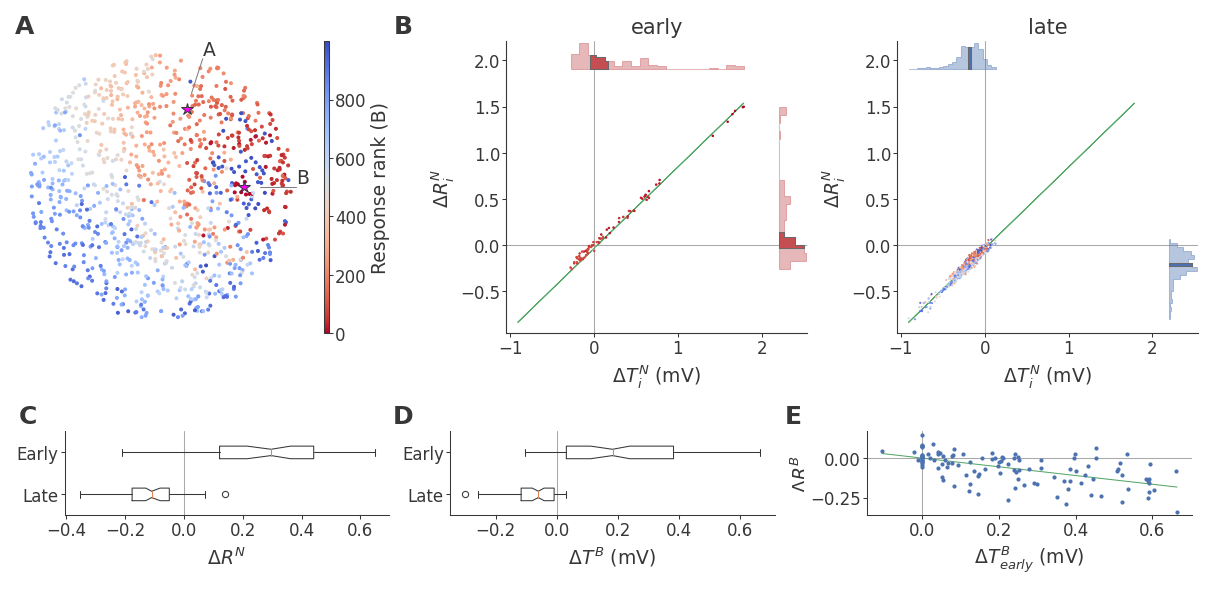

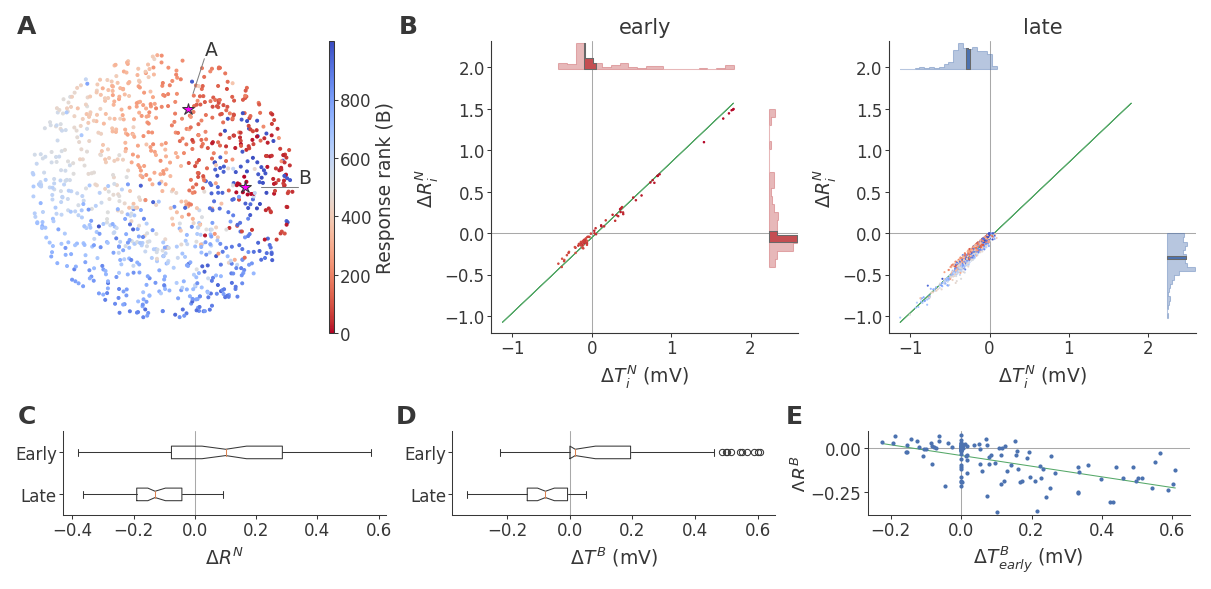

In [32]:
def make_figure_6(data, STD):
    fig = plt.figure(figsize=pu.fullwidth(3), dpi=150, layout='constrained')
    gs = fig.add_gridspec(2, 4, height_ratios=(1.6, 1), width_ratios=(3,.05,3,3))

    axs = [fig.add_subplot(gs[0, i]) for i in (0,1)]
    panel_RB_latency(*axs, data, ms=2)
    draw_stim_loc(axs[0])
    pu.label_panel(axs[0], 0)

    ax = fig.add_subplot(gs[0, 2])
    panel_early_sample(ax, data, portion='early')
    panel_early_sample(fig.add_subplot(gs[0, 3], sharex=ax, sharey=ax), data, portion='late')
    pu.label_panel(ax, 1, left=1.3)

    subfig_bottom = fig.add_subfigure(gs[1, :])
    gs_bottom = subfig_bottom.add_gridspec(1, 3)
    axs = [subfig_bottom.add_subplot(gs_bottom[i]) for i in (0,1)]
    panel_early_stats(axs, STD, vert=False)
    pu.label_panel(axs[0], 2, left=.8)
    pu.label_panel(axs[1], 3)

    ax = subfig_bottom.add_subplot(gs_bottom[2])
    panel_dTABearly_drives_dXB(ax, STD)
    pu.label_panel(ax, 4)

print('No STD:')
make_figure_6(half, 0)
plt.savefig('paper-1/Fig6.tif', pil_kwargs={"compression": "tiff_lzw"}, dpi=600)
plt.savefig('paper-1/fig-early-adaptation.pdf')

print('\nWith STD:')
make_figure_6(joint, 1)
plt.savefig('paper-1/S3_fig.pdf')

# F7: Adding STD

dXA(TA) less dXA(STD,TA): Z = -3.19, p = 0.000723
dXA medians: TA 0.04, TA+STD 0.0775, subtraction 0.0375, ratio 1.94


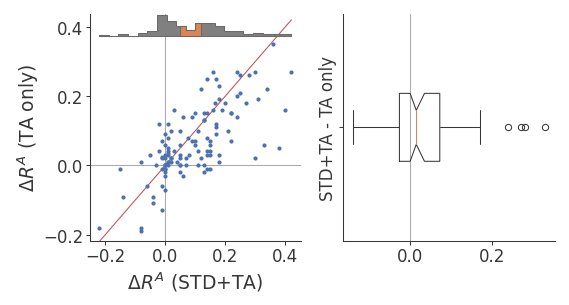

In [33]:
def panel_diff(ax_scatter, ax_box, stat='dXA', dstat='less', corr=None, dcorr='greater', exc=False, invert=False, br=' ', label=pu.R(stim='A')):
    def getdata(key):
        lim = cfg.params['N_exc'] if exc else cfg.params['N']
        if type(statistics[key][0]) == dict:
            return {STD: statistics[key][STD][1][:, :lim] for STD in cfg.STDs}
        else:
            return {STD: statistics[key][STD][:, :lim] for STD in cfg.STDs}
    sdata = getdata(stat)
    if corr is not None:
        cdata = getdata(corr)
        r = {STD: [] for STD in cfg.STDs}
        for STD in cfg.STDs:
            for cause, effect in zip(sdata[STD], cdata[STD]):
                regression = stats.linregress(cause, effect)
                r[STD].append(regression.rvalue)
        
        test = stats.wilcoxon(r[0], r[1], alternative=dcorr, method='approx')
        print(f'{stat} vs {corr}, rho(TA) {dcorr} rho(STD,TA): Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}')
        
    smed = [np.median(sdata[STD], 1) for STD in cfg.STDs]
    ax_scatter.plot(smed[1], smed[0], '.', ms=2, zorder=2)
    pu.inset_hist(ax_scatter, smed[1])
    lohi = smed[1].min(), smed[1].max()
    ax_scatter.plot(lohi, lohi, 'C3', zorder=1)
    ax_scatter.axhline(0, **styling.axline_kwargs)
    ax_scatter.axvline(0, **styling.axline_kwargs)
    ax_scatter.set_ylabel(f'$\\Delta {label}${br}(TA only)')
    if invert:
        sns.despine(ax=ax_scatter, top=False, bottom=True)
    else:
        sns.despine(ax=ax_scatter)
        ax_scatter.set_xlabel(f'$\\Delta {label}${br}(STD+TA)')

    ax_box.boxplot(smed[1] - smed[0], labels=('STD+TA - TA only',), notch=True, bootstrap=10000, vert=False, widths=.3, zorder=1)
    for label in ax_box.get_yticklabels():
        label.set_rotation(90)
        label.set_va('center')
    ax_box.axvline(0, **styling.axline_kwargs)
    sns.despine(ax=ax_box)

    test = stats.wilcoxon(*smed, alternative=dstat, method='approx')
    medsmed = list(map(np.median, smed))
    print(f'{stat}(TA) {dstat} {stat}(STD,TA): Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}')
    print(f'{stat} medians: TA {medsmed[0]:.3g}, TA+STD {medsmed[1]:3g}, subtraction {medsmed[1]-medsmed[0]:.3g}, ratio {medsmed[1]/medsmed[0]:.3g}')

fig, axs = plt.subplots(1, 2, figsize=(4,2), dpi=150)
panel_diff(*axs)

In [34]:
nspikes = dd.io.load('nspikes.h5')[cfg.ISIs[0]]

diff XA std < msc: Z = -1.67, p = 0.0474
diff XA msc < dev: Z = -2.54, p = 0.00554


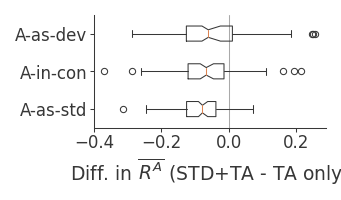

In [35]:
def panel_STD_response_reduction(ax):
    R_diff = [(nspikes[1][1][cond] - nspikes[0][1][cond]) / cfg.params['N'] for cond in conds]
    ax.boxplot(R_diff, notch=True, bootstrap=10000, widths=.4, vert=False, labels=[pu.seq[c] for c in conds], zorder=1)
    ax.axvline(0, **styling.axline_kwargs)
    ax.set_xlabel(f'Diff. in ${pu.R(stim="A", mean=True)}$ (STD+TA - TA only)')
    sns.despine(ax=ax)

    test = stats.wilcoxon(R_diff[0], R_diff[1], alternative='less', method='approx')
    print(f'diff XA std < msc: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.wilcoxon(R_diff[1], R_diff[2], alternative='less', method='approx')
    print(f'diff XA msc < dev: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}')
fig, ax = plt.subplots(figsize=(2,1), dpi=150)
panel_STD_response_reduction(ax)

diff XA std < msc: Z = -1.67, p = 0.0474
diff XA msc < dev: Z = -2.54, p = 0.00554

cf. Fig6 cd
dXnotA ~ dTA_B, rho > 0: Z = 9.51, p = 9.86e-22, median = 0.992
early dXnotA > 0: Z = 4.75, p = 1.02e-06
late dXnotA < 0: Z = -8.77, p = 9.19e-19
all dXnotA < 0: Z = -8.37, p = 2.91e-17
early dTA_B > 0: Z = 5.21, p = 9.51e-08
late dTA_B < 0: Z = -8.39, p = 2.49e-17
all dTA_B < 0: Z = -8.05, p = 4.17e-16

cf Fig5 d
dXnotA vs dTA_A, rho(TA) greater rho(STD,TA): Z = 2.11, p = 0.0175
dXnotA(TA) greater dXnotA(STD,TA): Z = 2.11, p = 0.0175
dXnotA medians: TA -0.0938, TA+STD -0.1275, subtraction -0.0338, ratio 1.36
rho > 0: Z = 9.51, p = 9.86e-22, median = 0.989
dXnotA < 0: Z = -8.32, p = 4.41e-17, median = -0.128

cf Fig4 e
dTA_A vs dXA, rho(TA) less rho(STD,TA): Z = -5.13, p = 1.49e-07
dTA_A(TA) greater dTA_A(STD,TA): Z = 1.95, p = 0.0257
dTA_A medians: TA -0.094, TA+STD -0.107013, subtraction -0.013, ratio 1.14
rho < 0: Z = -9.43, p = 2.09e-21, median = -0.268
dV_TA < 0: Z = -8.26, p = 7.29e-17

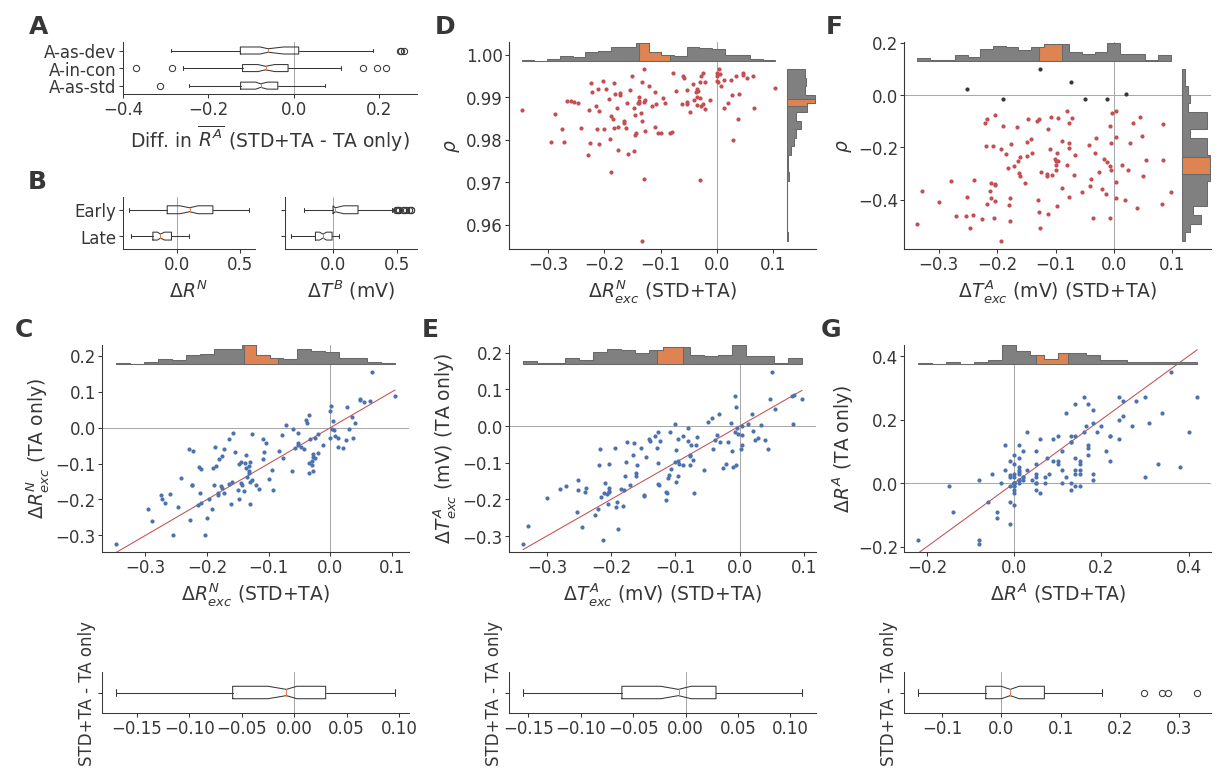

In [36]:
def make_figure_7():
    fig = plt.figure(figsize=pu.fullwidth(4), dpi=150, layout='constrained')
    gs = fig.add_gridspec(3, 3, height_ratios=(5,5,1))

    gs_a = gs[0,0].subgridspec(3,3, width_ratios=(.1,1,1), height_ratios=(1,.1,1))
    ax = fig.add_subplot(gs_a[0,1:])
    panel_STD_response_reduction(ax)
    pu.label_panel(ax, 0)

    print('\ncf. Fig6 cd')
    axs = [fig.add_subplot(gs_a[2,i]) for i in (1,2)]
    panel_early_stats(axs, 1, vert=False)
    axs[-1].set_yticklabels([])
    pu.label_panel(axs[0], 1, left=1.7)

    print('\ncf Fig5 d')
    axs = [fig.add_subplot(gs[i, 0]) for i in (1,2)]
    panel_diff(
        *axs,
        stat='dXnotA', corr='dTA_A', dstat='greater', dcorr='greater',
        exc=True, label=pu.R(stim='N', index='exc'))
    pu.label_panel(axs[0], 2)

    ax = fig.add_subplot(gs[0, 1])
    panel_dXnotA_drives_dTA(ax, 1, xsuffix=' (STD+TA)')
    pu.label_panel(ax, 3)

    print('\ncf Fig4 e')
    axs = [fig.add_subplot(gs[i, 1]) for i in (1,2)]
    panel_diff(
        *axs,
        stat='dTA_A', corr='dXA', dstat='greater', dcorr='less',
        exc=True, label=pu.T(stim='A', index='exc'), br=' (mV) ')
    pu.label_panel(axs[0], 4)

    ax = fig.add_subplot(gs[0, 2])
    panel_dTA_drives_dA(ax, 1, xsuffix=' (STD+TA)')
    pu.label_panel(ax, 5)

    axs = [fig.add_subplot(gs[i, 2]) for i in (1,2)]
    panel_diff(
        *axs,
        stat='dXA', dstat='less', corr=None,
        exc=False, label=pu.R(stim='A'))
    pu.label_panel(axs[0], 6)

make_figure_7()
plt.savefig('paper-1/Fig7.tif', pil_kwargs={"compression": "tiff_lzw"}, dpi=600)
plt.savefig('paper-1/fig-addingSTD.pdf')

# In response to reviewer 3: Overlap between "early" and "local" neurons in the demonstrator network

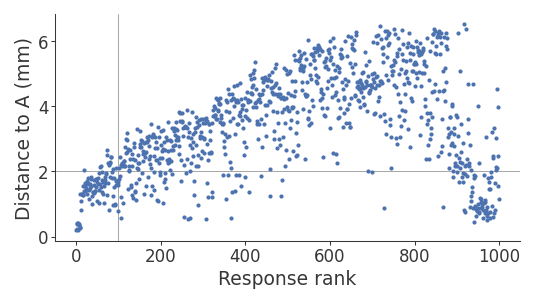

In [37]:
def scatter_early_rank_loc(ax, data):
    rank = np.argsort(data.index_N[:,0])
    mask = rank>-1#<early

    x, y = X[mask], Y[mask]
    distance = np.sqrt((x-Xstim[cfg.stimuli[stim]])**2 + (y-Ystim[cfg.stimuli[stim]])**2)
    
    ax.plot(rank[mask], distance/mm, 'o', ms=1)
    ax.axhline(2, **styling.axline_kwargs)
    ax.axvline(early, **styling.axline_kwargs)

    sns.despine(ax=ax)
    ax.set_xlabel('Response rank')
    ax.set_ylabel('Distance to A (mm)')

fig, ax = plt.subplots(figsize=pu.halfwidth(1.5), dpi=150, layout='constrained')
scatter_early_rank_loc(ax, joint)
plt.savefig('paper-1/S6_fig.pdf')